In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ua = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/user_artists.txt', skiprows = 1)
print(ua.shape)

ua_small = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/user_artists_small.txt', skiprows = 1)
print(ua_small.shape)

a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cse 547 - HW 2/artists.txt', sep = '\t')
a = np.array(a)
print(a.shape)

(62894, 3)
(265, 3)
(3000, 2)


In [4]:
# Check sparsity ratios
# print(62894 / (1882 * 3000 - 62894))
# print(265 / (100 * 100 - 265))

In [5]:
m = 1882
n = 3000
# m = 100
# n = 100
f = 3
lamda = 0.01
alpha = ua.shape[0] / (m * n - ua.shape[0])
print(alpha)
# alpha = ua_small.shape[0] / (100 * 100 - ua_small.shape[0])
# print(alpha)

X = sparse.csr_matrix(np.zeros((m, f)) + 0.5)
Y = sparse.csr_matrix(np.zeros((n, f)))

# construct the preference matrix and confidence matrix
# YOUR CODE HERE
P = np.zeros((m, n))
C = np.zeros((m, n))

# for triple in ua_small:
for triple in ua:
    P[int(triple[0]), int(triple[1])] = 1
    C[int(triple[0]), int(triple[1])] = alpha * triple[2]
P = sparse.csr_matrix(P)


0.011265055687640536


In [6]:
def ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER):

    """"
    X: initial user matrix
    Y: initial item matrix
    P: preference matrix
    C: confidence matrix
    """
    # construct lambda * I
    # YOUR CODE HERE
    lamda_eye = sparse.csr_matrix(lamda * np.eye(f))

    # array to store values of C_implicit
    C_implicit_arr = np.zeros(MAX_ITER + 1)


    for t in range(MAX_ITER):
        # update item matrix
        # YOUR CODE HERE
        xTx = X.T.dot(X)

        for item in range(n):
            p_i = P[:, item]
            C_i_I = sparse.diags(C[:, item], 0)
            left = xTx + X.T.dot(C_i_I.dot(X)) + lamda_eye # please use the trick in spec
            right = X.T.dot(C_i_I.dot(p_i)) + X.T.dot(p_i) # please use the trick in spec
            y_i = spsolve(left, right)
            Y[item] = y_i

        # update user matrix
        # YOUR CODE HERE
        yTy = Y.T.dot(Y)
        for user in range(m):
            p_u = P[user, :]
            p_u = p_u.T
            C_u_I = sparse.diags(C[user, :], 0)
            left = yTy + Y.T.dot(C_u_I.dot(Y)) + lamda_eye  # please use the trick in spec
            right = Y.T.dot(C_u_I.dot(p_u)) + Y.T.dot(p_u)  # please use the trick in spec
            x_u = spsolve(left, right)
            X[user] = x_u

        C_implicit_arr[t + 1] = cost(t + 1, n, m, C, P, X, Y, lamda);

    return X, Y, C_implicit_arr

In [7]:
# Function to calculate the cost after t iterations
def cost(t, n, m, C, P, X, Y, lamda):

    # Initialize
    C_implicit = 0

    # Compute the double sum using sparse matrices as much as possible
    for user in range(m):
        C_u = sparse.diags(C[user, :], 0)
        C_u += sparse.eye(C_u.shape[0])
        p_u = P[user, :]
        p_uT = p_u.T
        p_u2T = p_uT.power(2)
        x_u = X[user]

        prod1 = C_u.dot(p_u2T)
        sum1 = prod1.sum()

        Yxu = Y.dot(x_u.T)
        Yxu2 = Yxu.power(2)
        prod2 = C_u.dot(Yxu2)
        sum2 = prod2.sum()

        prod3 = (C_u.dot(p_uT)).T.dot(Yxu)
        sum3 = -2 * prod3.sum()

        C_implicit += sum1 + sum2 + sum3


    # Compute lamda times the Frobenius norms of X and Y
    C_implicit += lamda * sparse.linalg.norm(Y, 'fro') ** 2
    C_implicit += lamda * sparse.linalg.norm(X, 'fro') ** 2

    # Print and return the calculated cost
    print("C_implicit after ", t, " iterations = ", C_implicit)
    return C_implicit

In [8]:
# Run ALS algorithm

# Re-initialize the matrices X and Y
X = sparse.csr_matrix(np.zeros((m, f)) + 0.5)
Y = sparse.csr_matrix(np.zeros((n, f)))


# Calculate the initial C_implicit
c = cost(0, n, m, C, P, X, Y, lamda);


# Set the number of iterations
MAX_ITER = 100

# Here's the algorithm
Xnew, Ynew, C_implicits = ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER);
C_implicits[0] = c

C_implicit after  0  iterations =  685918.6402882527


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


C_implicit after  1  iterations =  320028.2019211311


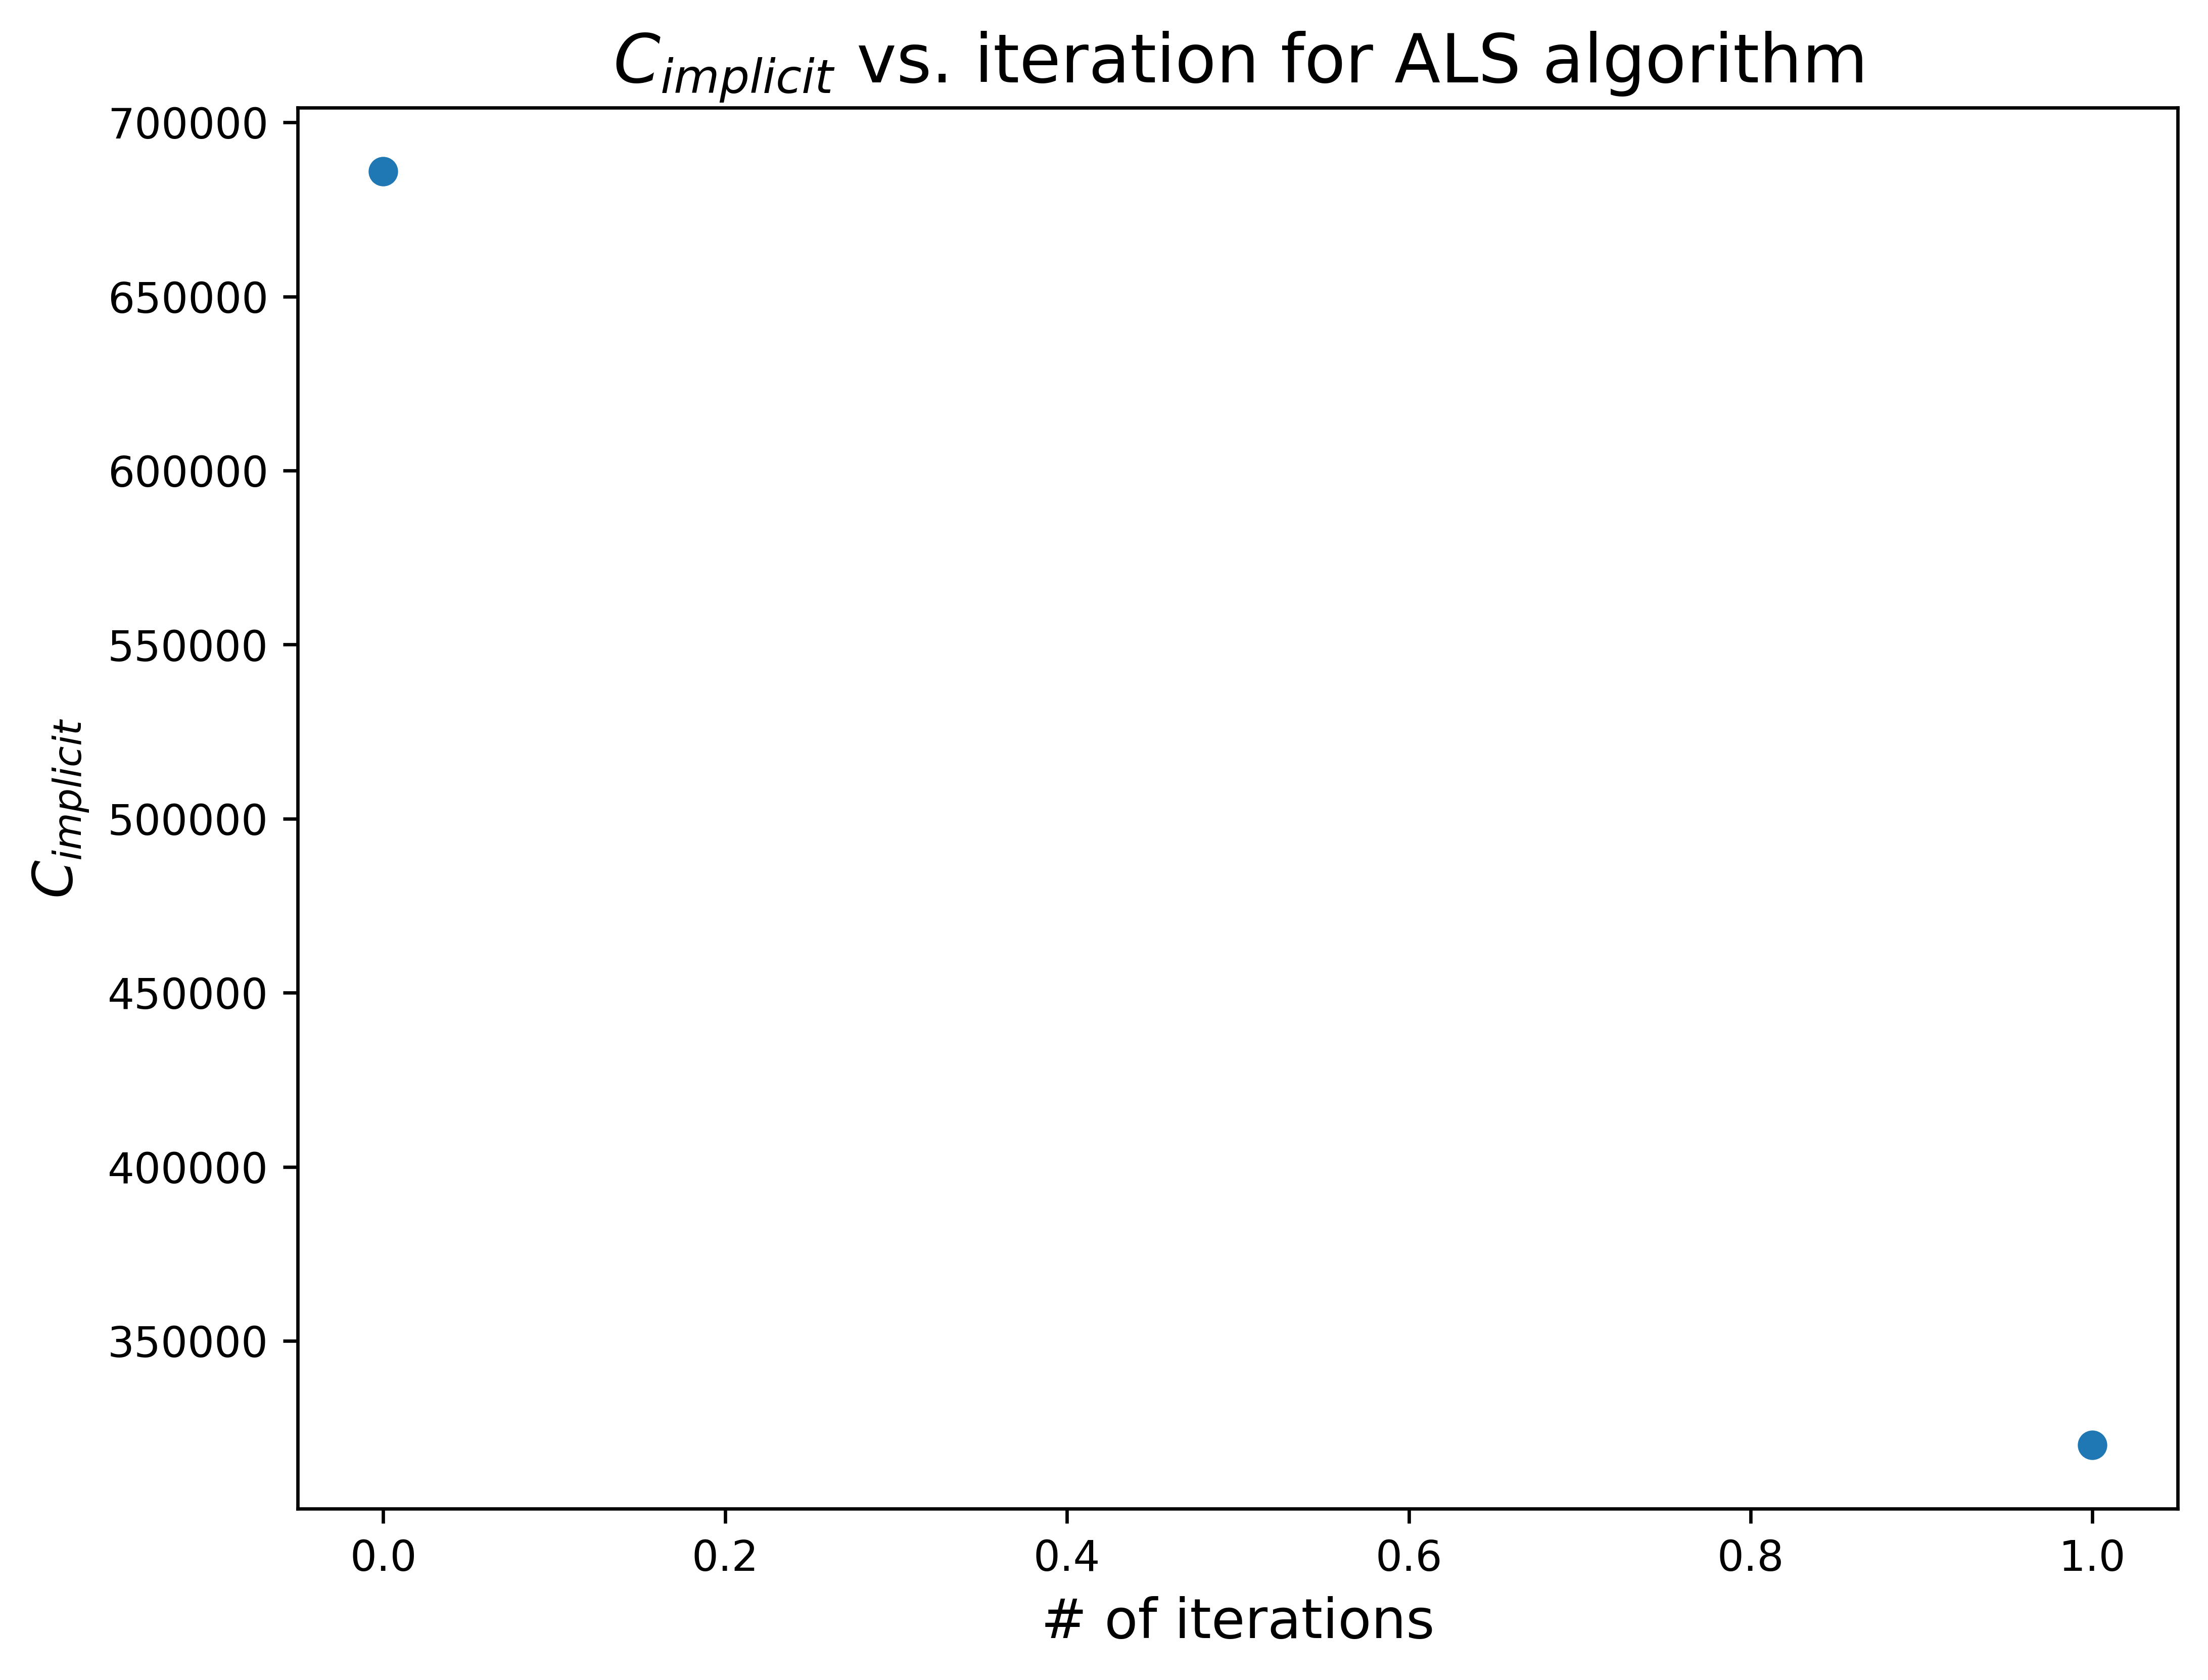

In [12]:
ts = np.linspace(0, MAX_ITER, MAX_ITER + 1)

plt.style.use('default');
plt.figure(figsize=(8, 6), dpi=600);
plt.scatter(ts, C_implicits);
plt.title("$C_{implicit}$ vs. iteration for ALS algorithm", fontsize = 16);
plt.xlabel("# of iterations", fontsize = 13);
plt.ylabel("$C_{implicit}$", fontsize = 13);
# plt.yscale('log');
# plt.xscale('log');
plt.show();

In [10]:
# Get Top Artist Recommendations for users 0, 20  (and 1 to check)

# Convert the updated sparse matrices X, Y to (dense) arrays
Xd = Xnew.toarray()
Yd = Ynew.toarray()


# For large dataset
for user in [0, 20]:

  print("Top 2 artist recommendations for user ", user)

  user_recs = np.matmul(Xd[user, :], Yd.T)
  for k in range(2):
    max_idx = np.argmax(user_recs)
    print(max_idx)
    user_recs[max_idx] = -10


# For small dataset (to check)
for user in [1]:

  print("Top 5 artist recommendations for user ", user)

  user_recs = np.matmul(Xd[user, :], Yd.T)
  for k in range(5):
    max_idx = np.argmax(user_recs)
    print(max_idx)
    user_recs[max_idx] = -10

Top 2 artist recommendations for user  0
283
83
Top 2 artist recommendations for user  20
283
83
Top 5 artist recommendations for user  1
283
83
66
286
282


In [11]:
print(a[2999])

[2999 'Louis Armstrong']
